** In this notebook were gonna explore the pareto distribution and see how the Cumulative Distribution Function of words in a text document follows this continuous distribution, also knows as Zipf's law**<br>

Zipf's law is an observation about how frequently different words are used in a text. The law states that the CCDF of the distribution of word counts in a big size of text is approximately pareto. To explore this, Im gonna plot the CCDF on a log-log scale. The CCDF of the pareto distribution is : $ (\frac{x}{x_m})^{-\alpha} $. Now if we take the log of both sides, the formula becomes: $log(y) = -\alpha(log\;x - log\;x_m )$. And this is the function we expect to get on a log-log scale. The slope of this line is $-\alpha$ and its intercept is $-\alpha \; log\;x_m$

In [1]:
import PyPDF2
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import numpy as np
import matplotlib.pyplot as plt
%config IPCompleter.greedy = True
from seaborn import lmplot
import pandas as pd
from statsmodels.api import OLS
from statsmodels.api import add_constant
from math import pow

/home/mohammad_14aug/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib notebook

I use the functions below to compute the Probability Mass Function, Cumulative Distribution Function, and the Complementary Cumulative Distribution Function of my data which is initially stored as a list.

In [3]:
def pmf_from_list(input_data):
    pmf = {}
    for data in input_data:
        if pmf.get(data) == None:
            pmf[data] = 1
        else:
            pmf[data] = pmf[data] + 1
    for key, value in pmf.items():
        pmf[key] = pmf[key] / len(input_data)
    return pmf
def cdf_from_pmf(pmf):
    cdf_keys = list(pmf.keys())
    cdf_values = list(pmf.values())
    for i in range(1, len(cdf_values)):
        cdf_values[i] = cdf_values[i] + cdf_values[i - 1]
    cdf = dict(zip(cdf_keys, cdf_values))
    return cdf
def ccdf_from_cdf(cdf):
    ccdf = [1 - x for x in list(cdf.values())]
    return dict(zip(cdf.keys(), ccdf))

Remember that were gonna be reading from a PDF file, which is stored in a binary fashion, so reading it is not as simple as reading a simple text file. hopefully, there is a very good library for python named PyPDF2, that helps us read PDF files and extract its text data. to extract all text data from a pdf file, these are the steps I perform:

1. open the PDF file in 'rb' mode (read binary) and store in an object, for example : PDFobject

2. we need to convert this binary file into a `PyPDF2.pdf.PdfFileReader` object

3. iterate the pages of this PDF document using the `PDFreader.getPage()` function which takes as argument a page number and returns a page object

4. extract the text on each page using the `extractText()` function of the page object.
<br><br>
one important thing to note is that the pdf document contatins lots of data that isn't in the form of words, such as punctuation marks and various symbols. and this noisy data needs to be removed as much as possible. I perform this using `re.sub`. I give as input a regex containing all the patterns i want to get rid of, and replace them all with a space. the regex pattern I provide is: `[$/.\'"!?;:,-\]\[)(}{]` , which gets rid of most of the noisy data. i also replace all the spaces with length greater than 1 with one single space.

In [4]:
file_path='Thinking-with-Type-A-Critical-Guide-for-Designers-Writers-Editors-Students.pdf'
PDfobject = open(file_path, 'rb')
PDFreader = PyPDF2.PdfFileReader(PDfobject)
num_pages = PDFreader.numPages
count = 0
text = ""
while count < num_pages:
    pageObj = PDFreader.getPage(count)
    count +=1
    text += pageObj.extractText()
text=re.sub('[$/.\'"!?;:,-\]\[)(}{]', '', text)
text = re.sub('\s+', ' ', text)
print(text[15000 : 17000])

conform with modern technologies and current demands for sharpness and uniformity ach revival responds toŠor reacts againstŠthe production methods printing styles and artistic habits of its own time ome revivals are based on metal types punches steel prototypes or drawings that still exist most rely solely on printed specimens talic letters also introduced in teenthcentury taly were modeled on a more casual style of handwriting hile the upright humanist scripts appeared in expensively produced books the cursive form thrived in the cheaper writing shops where it could be written more rapidly than the carefully formed lettera antica ldus anutius a enetian printer publisher and scholar used italic typefaces in his internationally distributed series of small inexpensive printed books or calligraphers the italic form was economical because it saved time while in printing the cursive form saved space ldus anutius often paired cursive letters with roman capitals the two styles still were cons

as we can see, The results after preprocessing look quite good. The book I used is the second edition of *Thinking With Type: A Critical Guide for Designers, Writers, Editors, Students*, Illustrated by **Ellen Lupton** and is one of the best books in the field of typography.<BR> Many PDF files won't give good results; the words stick together and the output just doesn't look right, so All we can do is hope that PyPDF2 extracts the text data properly for our PDF file. like with this very neet and tidy book.

** What im gonna do afterwards is im gonna split this big string of words by the spaces to get tokens, and create a bag of words with these tokens**

In [5]:
words = text.split(' ')
word_dict = {}
for word in words:
    if word_dict.get(word) == None:
        word_dict[word] = 1
    else:
        word_dict[word] = word_dict[word] + 1
print(len(word_dict))

7832


Finally the data is (Nearly!) ready for analysis. Im gonna store everything in a `Pandas` Dataframe, so that i can structurize my data and, use the `Pandas`, `Seaborn`, and the `statsmodels` libraries to analyze my data.

Im gonna first plot the CCDF of my data on an ordinary scale, and then plot it on a log-log scale. The plot on the log-log scale should be linear

*IF you look at the code carefully you realize that i removed the last row of my dataframe. this value is usually very small and can be considered as a outlier, so i decided to get rid of it*

             input      output  output_log   input_log
count   125.000000  125.000000  125.000000  125.000000
mean    143.064000    0.029826   -1.976670    1.795843
std     264.961219    0.061673    0.641768    0.560028
min       1.000000    0.000128   -3.893873    0.000000
25%      32.000000    0.004341   -2.362394    1.505150
50%      64.000000    0.010853   -1.964454    1.806180
75%     120.000000    0.028218   -1.549480    2.079181
max    1779.000000    0.490041   -0.309768    3.250176


<IPython.core.display.Javascript object>


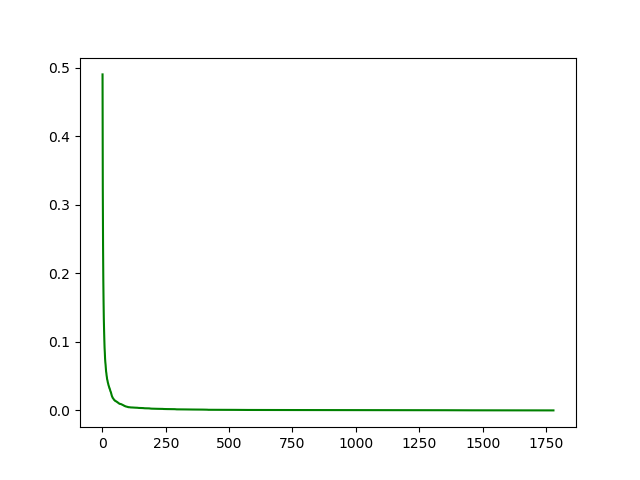

<IPython.core.display.Javascript object>


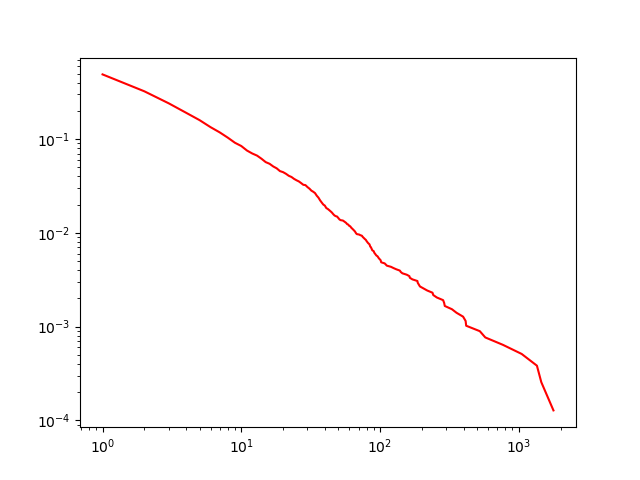

In [6]:
input_data = sorted(list(word_dict.values()))
data_ccdf = ccdf_from_cdf(cdf_from_pmf(pmf_from_list(input_data)))

input_data = np.asarray(list(data_ccdf.keys()))
input_data = np.expand_dims(input_data, axis = 1)

output_data = np.asarray(list(data_ccdf.values()), dtype = np.float64)
output_data = np.expand_dims(output_data, axis = 1)

df = pd.DataFrame(input_data, columns = ['input'])
df['output'] = output_data

df['output_log'] = df['output'].apply(lambda x : np.log10(x))
df['input_log'] = df['input'].apply(lambda x : np.log10(x))

#df['output'] = df['output'].fillna(df['output'].mean())
#df['output_log'] = df['output_log'].fillna(df['output_log'].mean())

df = df.drop([len(df) - 1])

print(df.describe())

plt.figure()
plt.plot(df['input'], df['output'], c='g')
plt.show()

plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.plot(df['input'], df['output'], c='r')
plt.show()

Im gonna fit this line with the linear regression algorithm. the `statsmodel.OLS` function is suitable for this job.

In [7]:
X = df['input_log']
y = df['output_log']
X = add_constant(X)
model = OLS(y, X).fit()
prediction = model.predict(X)
df['prediction'] = prediction

In [8]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             output_log   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 1.055e+04
Date:                Sun, 28 Oct 2018   Prob (F-statistic):          4.36e-121
Time:                        21:41:33   Log-Likelihood:                 157.55
No. Observations:                 125   AIC:                            -311.1
Df Residuals:                     123   BIC:                            -305.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0694      0.021      3.328      0.001       0.028       0.111
input_log     -1.1393      0.011   -102.731      0.000      -1.161      -1.117
==============================================================================
Omnibus:                       71.608   Durbin-Watson:                   0.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              390.016
Skew:                          -1.938   Prob(JB):                     2.04e-85
Kurtosis:                      10.737   Cond. No.                         8.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here we can see how the regression algorithm has tried to fit a line to the data

<IPython.core.display.Javascript object>


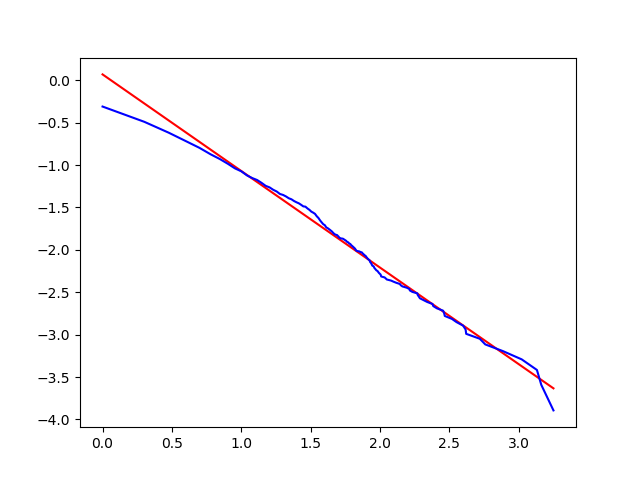

In [9]:
plt.figure()
plt.plot(df['input_log'], df['prediction'], c='r')
plt.plot(df['input_log'], df['output_log'], c = 'b')
plt.show()

<IPython.core.display.Javascript object>


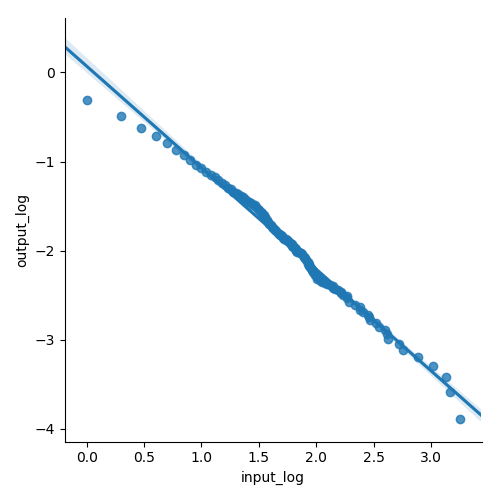

In [10]:
lmplot('input_log', 'output_log', df)

Now were gonna compute $\alpha$ and $x_m$ <br><br>
$y = (\frac{x}{x_m})^{-\alpha} \\ \\ log(y) = -\alpha(log\;x - log\;x_m) \\ \\ y = -1.13x + 0.07 \\ \\ \alpha = -1.13 \\ \\ y = 0 \; then \; 0.07 = -\alpha\;log\;x_m = -1.13\;log\;x_m \\ \\ x_m = 10^{\frac{0.07}{-1.13}} = 0.86 \\ \\ so\; we\; have\; : \alpha = 1.13 \; and \; x_m = 0.86  $ <br> Im gonna plot the line predicted with the actual line to visualize the results

<IPython.core.display.Javascript object>


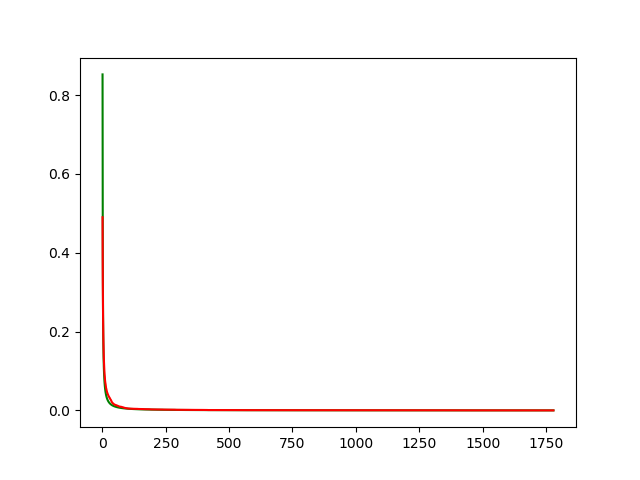

In [11]:
const = model.params[0]
input_log = model.params[1]
alpha = -input_log
x_m = pow(10, const / input_log)
y = df['input'].apply(lambda x : pow(x / x_m, -alpha))
plt.figure()
plt.plot(df['input'], y, c = 'g')
plt.plot(df['input'], df['output'], c = 'r')
plt.show()

There is a little error at the initial data values, which is understandable because linear regression also had a higher error a, but in total, the results look quite nice.